### 感知机

##### 参考：
- 《统计学习方法》（李航）
- 机器学习基石（林轩田）https://www.youtube.com/watch?v=WlpF1Phkv28&list=PLXVfgk9fNX2I7tB6oIINGBmW50rrmFTqf&index=7&t=0s

感知机是一个线性分类器；对于线性可分的样本，通过学习找出能够正确划分样本的超平面；对于不是线性可分的样本，通过学习找出一个在样本划分上犯错误尽可能少的超平面；

模型：
$$f(\vec{x}) = sign(\vec{w}\cdot\vec{x} + b)$$ 
<br>
$$sign(x) = \left\{ \begin{array}{rc}
            +1, & x \geqslant 0 \\ 
            -1, & x < 0
\end{array}\right.$$

损失函数： M为误分类点的集合 
$$L(\vec{w},b) = -\sum_{\vec{x_i} \in M}y_i(\vec{w} \cdot \vec{x_i} + b)$$

通过随机梯度下降法找到使损失函数最小的模型参数：$\vec{w}$, b
$$\nabla_\vec{w}L(\vec{w}, b) = -\sum_{\vec{x_i} \in M}y_i\vec{x_i}$$
<br>
$$\nabla_bL(\vec{w}, b) = -\sum_{\vec{x_i} \in M}y_i$$
<br>
$$\vec{w} \leftarrow \vec{w} + \eta y_i\vec{x_i}$$
<br>
$$b \leftarrow b + \eta y_i$$

当样本数据是线性可分时，通过迭代样本数据纠错，最终找到一个能够正确分类所有训练样本的超平面，停止迭代，此时的$\vec{w}$和b为一个解；

当样本数据不是线性可分时，如果一直迭代训练样本纠错，将永远无法停止迭代；此时需要使用口袋法，即预先设定一个迭代次数，在每次迭代中，随机选择一个错误样本进行纠错，求出当前模型误分类样本数，如果当前模型的误分类数比口袋中模型少，则用该模型替换口袋中模型；否则直接抛弃该模型；这样经过预先设定的迭代次数后，返回口袋中模型，该模型为整个过程中找到的最佳模型；

In [1]:
# 感知机口袋法的实现

import numpy as np

# 将模型的b移到向量W中，这样在训练和预测之前需要在每个特征前面插入一个常数1

class PerceptronM():
    
    def __init__(self, feature_dimension):
        self.w = [0] * feature_dimension

    # 预测单个数据
    def predictSingle(self, x):
        if np.dot(self.w, x) >= 0:
            return 1
        return -1
    
    # 批量预测
    def predictMulti(self, X):
        P = np.dot(X, self.w)
        P[P >= 0] = 1
        P[P < 0] = -1
        return P

    # 计算批量预测结果的误分类数
    def __err_count(self, X, Y):
        P = self.predictMulti(X)
        return np.count_nonzero(P!=Y)


    def train_model(self, X, Y, iter_num, eta=1):
        pos = list(range(0, Y.size))

        bestW = self.w
        bestE = np.Inf

        for i in range(iter_num):
            np.random.shuffle(pos)
            for p in pos:
                x = X[p]
                y = Y[p]
                if self.predictSingle(x) == y:
                    continue

                # x被误分类，对模型进行纠错
                self.w = self.w + eta * y * x 
                err = self.__err_count(X, Y)

                # 如果误分类数为0，直接返回最佳模型
                if err == 0:
                    return
                
                # 如果当前误分类数小于bestE，则保留当前模型
                if err < bestE:
                    bestW = self.w
                    bestE = err

        self.w = bestW

In [2]:
# 封装一个多类别分类感知器
class MultiClassPerceptron():
    
    def fit(self, X_train, Y_train):
        # digit_model中有多个PerceptronM模型，分别是targets中对应类别的识别模型
        self.targets = np.unique(Y_train)
        self.models = [PerceptronM(X_train.shape[1] + i) for i in [1] * len(self.targets)]
        sample_count = X_train.shape[0]
        X = np.hstack((np.array([1.] * sample_count).reshape((sample_count, 1)), X_train))
        for i in range(0, len(self.targets)):
            t = self.targets[i]
            Y = np.copy(Y_train)
            Y[Y!=t] = -1
            Y[Y==t] = 1
            self.models[i].train_model(X, Y, 50, 0.3)
        

    def __predict_one(self, x):
        for i in range(0, len(self.targets)):
            t = self.targets[i]
            if self.models[i].predictSingle(x) == 1:
                return t
        return -1


    def predict(self, X_Predict):
        Y = []
        sample_count = X_Predict.shape[0]
        X = np.hstack((np.array([1.] * sample_count).reshape((sample_count, 1)), X_Predict))
        for x in X:
            Y.append(self.__predict_one(x))
        return Y


CPU times: user 3.77 s, sys: 120 ms, total: 3.89 s
Wall time: 2.21 s
error rate: 0.07777777777777778


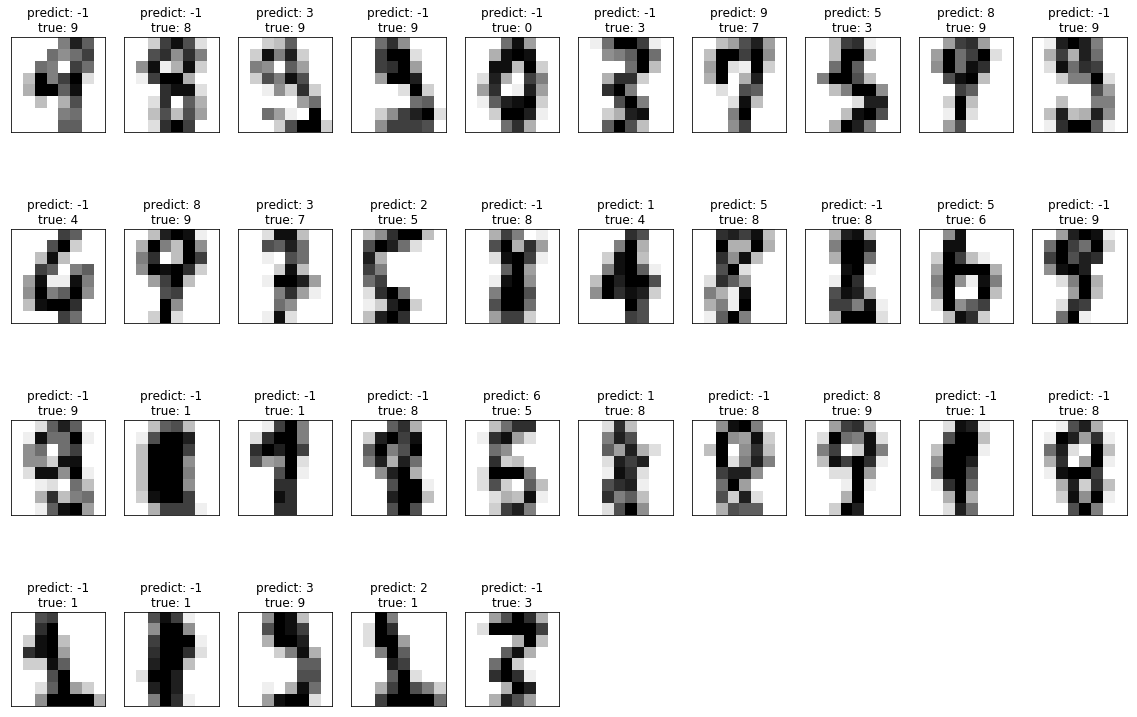

CPU times: user 1.07 s, sys: 46.2 ms, total: 1.12 s
Wall time: 1.03 s


In [3]:
# 使用sklearn的digits样本进行训练和预测
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

# 打印预测错误的信息和数字图片
def show_wrong_prediction(err_info):
    column = 10
    row = len(err_info) / column + 1
    f = plt.figure(1, figsize=(column * 2, row * 3))
    for i in range(0, len(err_info)):
        info = err_info[i]
        sp = f.add_subplot(row, column, i + 1)
        sp.imshow(info[2], aspect='equal', cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        sp.set_title('predict: %i\ntrue: %i' % (info[0], info[1]))
    plt.show()    


def test_digit_model(mcp, X, Y, show_err=False):
    err = 0
    total = X.shape[0]
    err_info = []
    for i in range(0, total):
        x = X[i]
        digit = mcp.predict(x.reshape(1, x.size))[0]
        if digit != Y[i]:
            err += 1
            err_info.append((digit, Y[i], x.reshape((8, 8))))
    print('error rate: %s' % (err * 1. / total))    
    
    if show_err:
         show_wrong_prediction(err_info)
    
    
digits = datasets.load_digits()
X, Y = digits.data, digits.target

rng = np.random.RandomState(42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=rng)

perceptron = MultiClassPerceptron()
%time perceptron.fit(X_train, Y_train)        
%time test_digit_model(perceptron, X_test, Y_test, True)

training SGD
training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG
training MCP


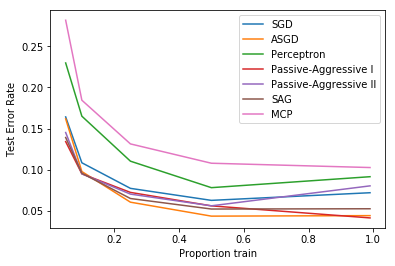

In [4]:
# 比较PerceptronM与sklearn.Perceptron
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20
digits = datasets.load_digits()
X, y = digits.data, digits.target

classifiers = [
    ("SGD", SGDClassifier(max_iter=100)),
    ("ASGD", SGDClassifier(average=True, max_iter=100)),
    ("Perceptron", Perceptron(tol=1e-3)),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge',
                                                         C=1.0, tol=1e-4)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',
                                                          C=1.0, tol=1e-4)),
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0])),
    ("MCP", MultiClassPerceptron())
]

xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

